In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling1D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import scipy.signal as ss

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# Welcome
This notebook will walk you through how to analyse brain wave data. This data was collected in the Neural Engineering Laboratory at the University of Missouri - Columbia. 

In [2]:
df = pd.read_csv('OpenBCI-RAW-2020-03-10_08-53-44.txt',skiprows=6,header=None)

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9
0,0,-76.20,1.38,-34.35,-51.09,0.912,0.112,-0.464,08:54:30.263,1.583848e+12
1,1,-36.12,29.01,76.34,48.51,0.912,0.112,-0.464,08:54:30.263,1.583848e+12
2,2,-43.59,31.42,58.11,30.55,0.912,0.112,-0.464,08:54:30.263,1.583848e+12
3,3,-77.29,2.68,-19.45,-49.45,0.912,0.112,-0.464,08:54:30.274,1.583848e+12
4,4,-57.05,17.48,52.08,23.03,0.912,0.112,-0.464,08:54:30.274,1.583848e+12


In [4]:
df.columns=['index','channel1','channel2','channel3','channel4','acc1','acc2','acc3','time_std','timestamp']
df.drop(['index'],axis=1,inplace=True)

In [5]:
df.head()

,channel1,channel2,channel3,channel4,acc1,acc2,acc3,time_std,timestamp
0,-76.20,1.38,-34.35,-51.09,0.912,0.112,-0.464,08:54:30.263,1.583848e+12
1,-36.12,29.01,76.34,48.51,0.912,0.112,-0.464,08:54:30.263,1.583848e+12
2,-43.59,31.42,58.11,30.55,0.912,0.112,-0.464,08:54:30.263,1.583848e+12
3,-77.29,2.68,-19.45,-49.45,0.912,0.112,-0.464,08:54:30.274,1.583848e+12
4,-57.05,17.48,52.08,23.03,0.912,0.112,-0.464,08:54:30.274,1.583848e+12


# Explanation of the data
As you can see the dataframe consists of 8 columns. Each row is a sample. The data was sampled at 200 Hz. That means 200 samples per second. There are four channels on the EEG device, two of these were place on the frontal lobe (forehead) and two on the temporal lobe (sides of the head). The acc1-3 channels are the accelerometer. If the subject moves, these channels will detect that. The time is represented by the final two columns.

Below, we will plot the entire time course of one channel.

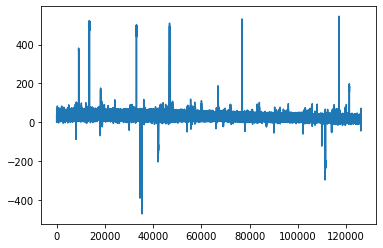

In [6]:
plt.figure()
plt.plot(df['channel2'])

# Remove drift
The mean of the data changes over time. This is called drift. We can remove this trend in the data using scipy's detrend function.

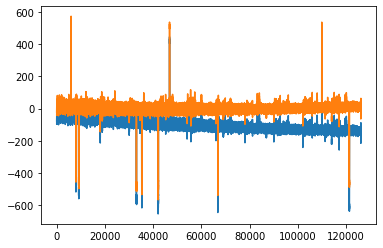

In [7]:
plt.plot(df['channel1'])
plt.plot(ss.detrend(df['channel1']))

In [8]:
df['channel1'] = ss.detrend(df['channel1'])
df['channel2'] = ss.detrend(df['channel2'])
df['channel3'] = ss.detrend(df['channel3'])
df['channel4'] = ss.detrend(df['channel4'])

# Artifact removal
Whenever the subject moved or blinked, there is a large deviation in the potential of all channels. We need to remove these.

In [9]:
zchan1 = (df['channel1']-np.mean(df['channel1']))/np.std(df['channel1'])
zchan2 = (df['channel2']-np.mean(df['channel2']))/np.std(df['channel2'])
zchan3 = (df['channel3']-np.mean(df['channel3']))/np.std(df['channel3'])
zchan4 = (df['channel4']-np.mean(df['channel4']))/np.std(df['channel4'])

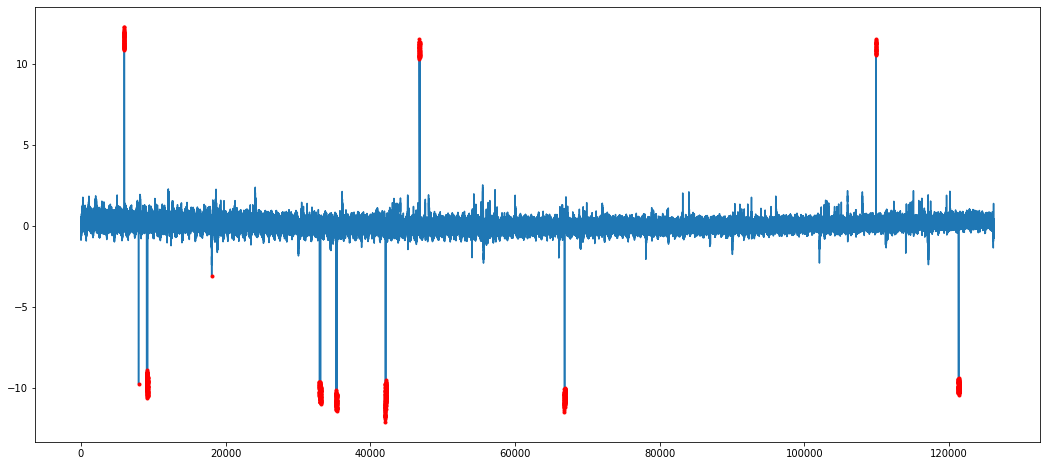

In [10]:
plt.figure(figsize=(18,8))
plt.plot(zchan1)
plt.plot(zchan1[np.abs(zchan1)>3],'r.')

Most of these are artifacts.

# Make y labels
The subject was in two states during the experiment; their eyes were either open or closed. Below, we define the times at which the eyes were open or closed.

In [11]:
df['seconds_from_start']=(df['timestamp']-df['timestamp'].iloc[0])/1000

In [12]:
y_labels = np.zeros((df['time_std'].shape[0],1))

In [13]:
y_labels[(60<df.seconds_from_start)&(df.seconds_from_start<90)] = 1
y_labels[(120<df.seconds_from_start)&(df.seconds_from_start<150)] = 1
y_labels[(180<df.seconds_from_start)&(df.seconds_from_start<210)] = 1
y_labels[(240<df.seconds_from_start)&(df.seconds_from_start<270)] = 1
y_labels[(300<df.seconds_from_start)&(df.seconds_from_start<330)] = 1
y_labels[(360<df.seconds_from_start)&(df.seconds_from_start<390)] = 1
y_labels[(420<df.seconds_from_start)&(df.seconds_from_start<450)] = 1
y_labels[(480<df.seconds_from_start)&(df.seconds_from_start<510)] = 1
y_labels[(540<df.seconds_from_start)&(df.seconds_from_start<570)] = 1
y_labels[(600<df.seconds_from_start)&(df.seconds_from_start<630)] = 1

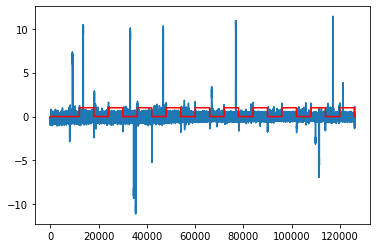

In [14]:
plt.plot(zchan2)
plt.plot(y_labels,'r')

In the plot above, the trace of a single channel is shown in blue and whether or not the eyes were closed is shown in red. y_labels == 1 means eyes closed and y_labels == 0 means eyes open.

Remove 60 Hz noise and artifacts. Any time a signal is recorded inside of a building, there will be a prominent 60 Hz noise from the power lines. We will remove this using a notch filter.

In [15]:
b, a = ss.iirnotch(60.0, 200.0, 200.)

zchan1 = ss.filtfilt(b,a,zchan1)
zchan2 = ss.filtfilt(b,a,zchan2)
zchan3 = ss.filtfilt(b,a,zchan3)
zchan4 = ss.filtfilt(b,a,zchan4)

zchan1[np.abs(zchan1)>3] = np.nan
zchan2[np.abs(zchan2)>3] = np.nan
zchan3[np.abs(zchan3)>3] = np.nan
zchan4[np.abs(zchan4)>3] = np.nan
y_labels[(np.abs(zchan1)>3) | (np.abs(zchan2)>3) | (np.abs(zchan3)>3) | (np.abs(zchan4)>3)] = np.nan

In [16]:
df['channel1'] = zchan1
df['channel2'] = zchan2
df['channel3'] = zchan3
df['channel4'] = zchan4
df['y_labels'] = y_labels

The below graph shows the difference between eyes closed and eyes open in the frequency domain. It is well known that the eyes closed condition generates alpha waves at 8-12 Hz, which we also see in this recording. There may still be some 60 Hz noise that our notch filter failed to remove.

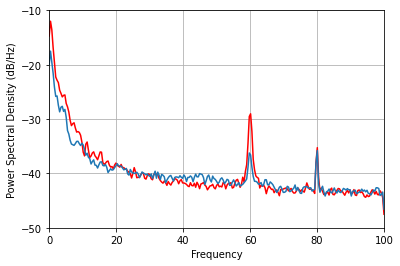

In [17]:
X = df['channel2'].iloc[y_labels[:,0]==0]
plt.psd(X[~np.isnan(X)],512,Fs=200,color='r')
X = df['channel2'].iloc[y_labels[:,0]==1]
plt.psd(X[~np.isnan(X)],512,Fs=200)
plt.xlim(0,100)
#plt.show()
plt.show()

In [18]:
from scipy.integrate import simps
import scipy.stats as sst
from matplotlib.mlab import psd

def bandpower(trace,band):
    [a1,f1]=psd(trace[~np.isnan(trace)],512,Fs=200)
    total_power1 = simps(a1, dx=0.1)
    ap1 = simps(a1[(f1>band[0]) & (f1<band[1])], dx=0.1)
    return ap1/total_power1
    
input_mat = np.zeros((600,21))
c=0
for i in np.arange(0,120000,200):
    
    X1=df['channel1'];X2=df['channel2'];X3=df['channel3'];X4 = df['channel4']
    Y = df['y_labels']
    
    X1=X1[i:i+200];X2=X2[i:i+200];X3=X3[i:i+200];X4=X4[i:i+200]
    Y=Y[i:i+200]
    
    input_mat[c,0] = bandpower(X1,[8,12]);input_mat[c,1] = bandpower(X2,[8,12]);
    input_mat[c,2] = bandpower(X3,[8,12]);input_mat[c,3] = bandpower(X4,[8,12]);
    
    input_mat[c,4] = bandpower(X1,[3,8]);input_mat[c,5] = bandpower(X2,[3,8]);
    input_mat[c,6] = bandpower(X3,[3,8]);input_mat[c,7] = bandpower(X4,[3,8]);
    
    input_mat[c,8] = bandpower(X1,[12,38]);input_mat[c,9] = bandpower(X2,[12,38]);
    input_mat[c,10] = bandpower(X3,[12,38]);input_mat[c,11] = bandpower(X4,[12,38]);
    
    input_mat[c,12] = bandpower(X1,[38,100]);input_mat[c,13] = bandpower(X2,[38,100]);
    input_mat[c,14] = bandpower(X3,[38,100]);input_mat[c,15] = bandpower(X4,[38,100]);
    
    input_mat[c,16] = bandpower(X1,[0.5,3]);input_mat[c,17] = bandpower(X2,[0.5,3]);
    input_mat[c,18] = bandpower(X3,[0.5,3]);input_mat[c,19] = bandpower(X4,[0.5,3]);
    
    [u,n] = np.unique(Y,return_counts=True)
    if n.shape[0]==1:
        input_mat[c,-1] = u[0].astype(int)
    else:
        input_mat[c,-1] = np.nan
        
    c+=1

feat_eng_df = pd.DataFrame(input_mat, columns = ['alpha_power_1','alpha_power_2','alpha_power_3','alpha_power_4',
                                                 'theta_power_1','theta_power_2','theta_power_3','theta_power_4',
                                                 'beta_power_1','beta_power_2','beta_power_3','beta_power_4',
                                                 'gamma_power_1','gamma_power_2','gamma_power_3','gamma_power_4',
                                                 'delta_power_1','delta_power_2','delta_power_3','delta_power_4',
                                                 'eyes_closed'])

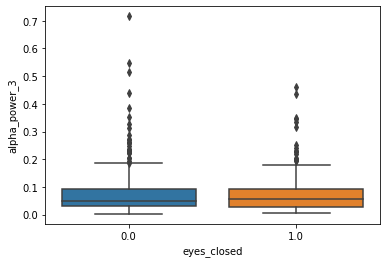

In [19]:
import seaborn as sns
sns.boxplot(x='eyes_closed',y='alpha_power_3',data=feat_eng_df)

# Feature Engineering Model

In [20]:
from sklearn.preprocessing import scale

train_df = feat_eng_df.iloc[0:420,:]
test_df = feat_eng_df.iloc[420:,:]

train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

X_train = train_df.iloc[:,:-1]
y_train = train_df.iloc[:,-1]
X_test = test_df.iloc[:,:-1]
y_test = test_df.iloc[:,-1]

X_train = X_train[~np.isnan(y_train)]
y_train = y_train[~np.isnan(y_train)]
X_test = X_test[~np.isnan(y_test)]
y_test = y_test[~np.isnan(y_test)]


X_train = scale(X_train)
X_test = scale(X_test)

In [21]:
X_train.shape, X_test.shape

((408, 20), (174, 20))

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

lr = LogisticRegression(random_state=231)
rf = RandomForestClassifier(random_state=2124)
mlp = MLPClassifier(hidden_layer_sizes=(5,),early_stopping=True,max_iter=1000,random_state=12)

lr.fit(X_train,y_train.values)
rf.fit(X_train,y_train.values)
mlp.fit(X_train,y_train.values)

yhatlr = lr.predict(X_test)
yhatrf = rf.predict(X_test)
yhatmlp = mlp.predict(X_test)

print(confusion_matrix(y_test,yhatlr))
print(confusion_matrix(y_test,yhatrf))
print(confusion_matrix(y_test,yhatmlp))

[[72 15]
 [31 56]]
[[58 29]
 [34 53]]
[[65 22]
 [67 20]]


##### STUDENTS, ASSIGNMENT STOPS HERE #####

# Model raw data

Below we transform the data into a frame suitable for supervised learning. A window size of 50 represents 0.25 seconds.

In [23]:
df_train = df[df.seconds_from_start<=420]
df_test = df[df.seconds_from_start>420]

In [24]:
df_train.head()

,channel1,channel2,channel3,channel4,acc1,acc2,acc3,time_std,timestamp,seconds_from_start,y_labels
0,-0.219697,-0.774254,-0.099779,-0.503364,0.912,0.112,-0.464,08:54:30.263,1.583848e+12,0.000,0.0
1,0.253886,-0.442505,1.015076,0.527823,0.912,0.112,-0.464,08:54:30.263,1.583848e+12,0.000,0.0
2,0.111783,-0.453969,0.839341,0.320779,0.912,0.112,-0.464,08:54:30.263,1.583848e+12,0.000,0.0
3,-0.232359,-0.767459,0.220389,-0.413223,0.912,0.112,-0.464,08:54:30.274,1.583848e+12,0.011,0.0
4,-0.051354,-0.574461,0.868939,0.340731,0.912,0.112,-0.464,08:54:30.274,1.583848e+12,0.011,0.0


In [25]:
from tqdm import tqdm_notebook

window_size = 50
stride=20

df_class_train = np.zeros((int(df_train.shape[0]/stride),window_size+1,4))
c=0
for i in tqdm_notebook(np.arange(0,df_train.shape[0]-window_size,stride)):
    df_class_train[c,0:window_size,0] = df_train['channel1'].iloc[i:i+window_size]
    df_class_train[c,0:window_size,1] = df_train['channel2'].iloc[i:i+window_size]
    df_class_train[c,0:window_size,2] = df_train['channel3'].iloc[i:i+window_size]
    df_class_train[c,0:window_size,3] = df_train['channel4'].iloc[i:i+window_size]
    
    ylabs = df_train['y_labels'].iloc[i:i+window_size]
    ones=ylabs[ylabs==1]
    zeros=ylabs[ylabs==0]
    
    if ones.shape[0]>zeros.shape[0]:
        df_class_train[c,-1,:] = 1
    else:
        df_class_train[c,-1,:] = 0
    c+=1
    
df_class_test = np.zeros((int(df_test.shape[0]/stride),window_size+1,4))
c=0
for i in tqdm_notebook(np.arange(0,df_test.shape[0]-window_size,stride)):
    df_class_test[c,0:window_size,0] = df_test['channel1'].iloc[i:i+window_size]
    df_class_test[c,0:window_size,1] = df_test['channel2'].iloc[i:i+window_size]
    df_class_test[c,0:window_size,2] = df_test['channel3'].iloc[i:i+window_size]
    df_class_test[c,0:window_size,3] = df_test['channel4'].iloc[i:i+window_size]
    
    ylabs = df_test['y_labels'].iloc[i:i+window_size]
    ones=ylabs[ylabs==1]
    zeros=ylabs[ylabs==0]
    
    if ones.shape[0]>zeros.shape[0]:
        df_class_test[c,-1,:] = 1
    else:
        df_class_test[c,-1,:] = 0
    c+=1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/4197 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2109 [00:00<?, ?it/s]

Remove NaN rows

In [26]:
df_class_train = df_class_train[~np.isnan(df_class_train[:,:-1,0]).any(axis=1),:,:]
df_class_train = df_class_train[~np.isnan(df_class_train[:,:-1,1]).any(axis=1),:,:]
df_class_train = df_class_train[~np.isnan(df_class_train[:,:-1,2]).any(axis=1),:,:]
df_class_train = df_class_train[~np.isnan(df_class_train[:,:-1,3]).any(axis=1),:,:]

df_class_test = df_class_test[~np.isnan(df_class_test[:,:-1,0]).any(axis=1),:,:]
df_class_test = df_class_test[~np.isnan(df_class_test[:,:-1,1]).any(axis=1),:,:]
df_class_test = df_class_test[~np.isnan(df_class_test[:,:-1,2]).any(axis=1),:,:]
df_class_test = df_class_test[~np.isnan(df_class_test[:,:-1,3]).any(axis=1),:,:]

In [27]:
df_class_train.shape,df_class_test.shape

((4061, 51, 4), (2064, 51, 4))

# Feature engineering

Here I manually engineer some features and try some basic models on that transformed data.

In [28]:
df_class_train.shape

(4061, 51, 4)

In [29]:
import scipy
################ TRAIN #######################
X=np.mean(df_class_train[:,:-1,:],axis=1)
Y=np.var(df_class_train[:,:-1,:],axis=1)
Z=scipy.stats.skew(df_class_train[:,:-1,:],axis=1)
W=scipy.stats.kurtosis(df_class_train[:,:-1,:],axis=1)

ds = np.concatenate((X,Y,Z,W,df_class_train[:,-1,0:1]),axis=1)
np.random.shuffle(ds) 

df_feats_train = pd.DataFrame(ds,columns=['meanch1','meanch2','meanch3','meanch4',\
                                    'varch1','varch2','varch3','varch4',\
                                    'skewch1','skewch2','skewch3','skewch4',\
                                    'kurtch1','kurtch2','kurtch3','kurtch4','output'])
################ TEST #######################
X=np.mean(df_class_test[:,:-1,:],axis=1)
Y=np.var(df_class_test[:,:-1,:],axis=1)
Z=scipy.stats.skew(df_class_test[:,:-1,:],axis=1)
W=scipy.stats.kurtosis(df_class_test[:,:-1,:],axis=1)

ds = np.concatenate((X,Y,Z,W,df_class_test[:,-1,0:1]),axis=1)
np.random.shuffle(ds) 

df_feats_test = pd.DataFrame(ds,columns=['meanch1','meanch2','meanch3','meanch4',\
                                    'varch1','varch2','varch3','varch4',\
                                    'skewch1','skewch2','skewch3','skewch4',\
                                    'kurtch1','kurtch2','kurtch3','kurtch4','output'])

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

rf = RandomForestClassifier()
lr = LogisticRegression()
pca = PCA()

X_train = df_feats_train.loc[:, df_feats_train.columns != 'output']
y_train = df_feats_train.loc[:, df_feats_train.columns == 'output']

X_test = df_feats_test.loc[:, df_feats_test.columns != 'output']
y_test = df_feats_test.loc[:, df_feats_test.columns == 'output']


#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=212)

rf.fit(X_train,y_train)
lr.fit(X_train,y_train)
pca.fit(X_train,y_train)

yhat_rf = rf.predict(X_test)
yhat_lr = lr.predict(X_test)

print(confusion_matrix(y_test,yhat_rf))
print(confusion_matrix(y_test,yhat_lr))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[664 233]
 [610 557]]
[[630 267]
 [565 602]]


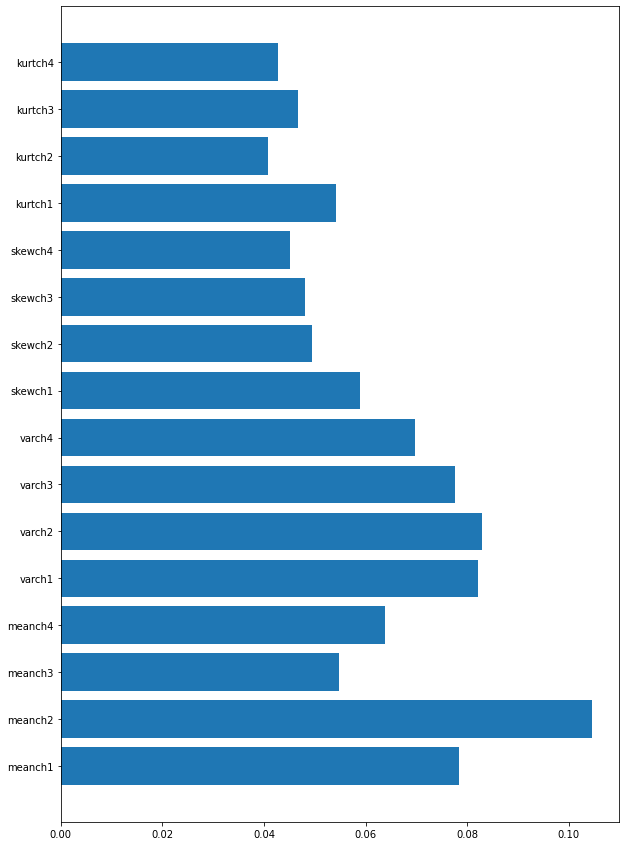

In [31]:
plt.figure(figsize=(10,15))
y_pos = np.arange(len(X_train.columns))
plt.barh(y_pos, rf.feature_importances_)
 
# Create names on the y-axis
plt.yticks(y_pos, X_train.columns)
plt.show()

In [32]:
#import seaborn as sns
#sns.pairplot(pd.concat((X_train[['meanch4']],y_train),axis=1),hue='output')

In [33]:
#sns.scatterplot(x='meanch4',y='varch2',hue='output',data=pd.concat((X_train,y_train),axis=1))
#plt.show()

In [34]:
def focal_loss(gamma=4, alpha=0.15):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

# load the dataset, returns train and test X and y elements
def load_dataset(dftrain,dftest):
    trainX = dftrain[:,:-1,:]
    trainy = dftrain[:,-1,0:1]
    
    testX = dftest[:,:-1,:]
    testy = dftest[:,-1,0:1]
    
    shuff_idx = np.random.choice(np.arange(0,trainX.shape[0]),trainX.shape[0],replace=False)
    trainX = trainX[shuff_idx,:,:]
    trainy = trainy[shuff_idx]
    
    shuff_idx = np.random.choice(np.arange(0,testX.shape[0]),testX.shape[0],replace=False)
    testX = testX[shuff_idx,:,:]
    testy = testy[shuff_idx]

    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy

# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 1, 200, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    er = EarlyStopping(patience=10, min_delta=1e-4, monitor='val_accuracy')
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, 
              validation_split=0.15, callbacks=[er])
    return model

# fit and evaluate a model
def evaluate_model2d(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 1, 20, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    input_layer = Input(shape=(trainX.shape[1], trainX.shape[2], trainX.shape[3]))

    # handle image dimensions ordering
    if tf.keras.backend.image_data_format() == 'channels_first':
        latent = Permute((3, 1, 2))(input_layer)
    else:
        latent = input_layer

    # define the network architecture
    latent = Conv2D(filters=32, kernel_size=(3, 3),
                        activation='relu')(latent)
    latent = Conv2D(filters=64, kernel_size=(3, 3),
                        activation='relu')(latent)
    latent = Dropout(0.5)(latent)
    latent = MaxPooling2D(pool_size=(2, 2))(latent)
    latent = Flatten()(latent)
    latent = Dense(units=100, activation='relu')(latent)
    output_layer = Dense(units=trainy.shape[1], activation='softmax')(latent)

    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    er = EarlyStopping(patience=10, min_delta=1e-4, monitor='val_accuracy')
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, 
              validation_split=0.15, callbacks=[er])
    return model

# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

# run an experiment
def run_experiment():
    # load data
    
    trainX, trainy, testX, testy = load_dataset(df_class_train,df_class_test)
    # repeat experiment
    scores = list()
    
    model = evaluate_model(trainX, trainy, testX, testy)
    
    ypred = model.predict(testX)
    class_preds = np.argmax(ypred, axis=-1)
    testy = np.argmax(testy,axis=-1)

    from sklearn.metrics import confusion_matrix
    print(confusion_matrix(testy,class_preds))
    return model

In [35]:
model = run_experiment()

(4061, 50, 4) (4061, 2) (2064, 50, 4) (2064, 2)
Epoch 1/200
108/108 [==============================] - 4s 22ms/step - loss: 0.6385 - accuracy: 0.5946 - val_loss: 0.5998 - val_accuracy: 0.6344
Epoch 2/200
108/108 [==============================] - 2s 20ms/step - loss: 0.5939 - accuracy: 0.6500 - val_loss: 0.5802 - val_accuracy: 0.6541
Epoch 3/200
108/108 [==============================] - 2s 19ms/step - loss: 0.5670 - accuracy: 0.6850 - val_loss: 0.5491 - val_accuracy: 0.7066
Epoch 4/200
108/108 [==============================] - 2s 18ms/step - loss: 0.5371 - accuracy: 0.7123 - val_loss: 0.5250 - val_accuracy: 0.7115
Epoch 5/200
108/108 [==============================] - 2s 18ms/step - loss: 0.5042 - accuracy: 0.7409 - val_loss: 0.4978 - val_accuracy: 0.7393
Epoch 6/200
108/108 [==============================] - 2s 19ms/step - loss: 0.4516 - accuracy: 0.7809 - val_loss: 0.4360 - val_accuracy: 0.7902
Epoch 7/200
108/108 [==============================] - 2s 18ms/step - loss: 0.4339 - acc

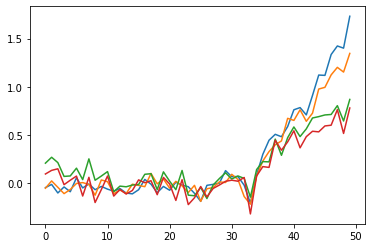

In [36]:
%matplotlib inline
plt.plot(df_class_test[0,:-1,0])
plt.plot(df_class_test[0,:-1,1])
plt.plot(df_class_test[0,:-1,2])
plt.plot(df_class_test[0,:-1,3])